# Data processing

## Read and Preprocess data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import pyro
pyro.__version__

'1.5.1'

In [ ]:
def create_mapping(list1, list2):
	return dict(zip(list1, list2))
def convert_mapping(mapping, encode_list):
	return list(map(lambda x: mapping[x], encode_list))

In [ ]:
data_full = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx", dtype=str)
data_full.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
for col in ['UnitPrice', 'Quantity']:
    data_full[col] = np.array(data_full[col]).astype(float)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  float64
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(2), object(6)
memory usage: 33.1+ MB


In [ ]:
np.random.seed(0)
Invoice_list = data_full.InvoiceNo.unique()
rand_idx = np.random.randint(0, len(Invoice_list), len(Invoice_list))
Invoice_train, Invoice_test = Invoice_list[rand_idx][:int(0.9*len(Invoice_list))], Invoice_list[rand_idx][int(0.9*len(Invoice_list)):]
data, test_data = data_full[data_full.InvoiceNo.isin(Invoice_train)], data_full[data_full.InvoiceNo.isin(Invoice_test)]
print (len(Invoice_train), data.InvoiceNo.nunique(), len(Invoice_test), test_data.InvoiceNo.nunique())
data.head()

23310 15411 2590 2474


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7,536366,22633,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,2010-12-01 08:34:00,1.69,13047,United Kingdom
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6.0,2010-12-01 08:34:00,2.10,13047,United Kingdom
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6.0,2010-12-01 08:34:00,2.10,13047,United Kingdom


In [ ]:
Invoice_list = data_full.InvoiceNo.unique()
data['StockCode']=data['StockCode'].apply(lambda r: r.upper())
data['Invalid_Description'] = data['Description'].apply(lambda r: r.isupper()==False if pd.isnull(r)==False else True)
data = data[data.Invalid_Description==False]
del data['Invalid_Description']

product_id = data[['StockCode', 'Description']].drop_duplicates(subset='StockCode')
stock2dec_mapping = create_mapping(product_id.StockCode, product_id.Description)
print (len(product_id))
product_id.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


3696


,StockCode,Description
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT
10,22745,POPPY'S PLAYHOUSE BEDROOM
11,22748,POPPY'S PLAYHOUSE KITCHEN


In [ ]:
product_id = data[['StockCode', 'Description']].drop_duplicates(subset='StockCode')
print (len(product_id))
product_id.head()

3696


,StockCode,Description
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT
10,22745,POPPY'S PLAYHOUSE BEDROOM
11,22748,POPPY'S PLAYHOUSE KITCHEN


## Prepare matrix training data

In [ ]:
data['Month'] = data.InvoiceDate.apply(lambda r: str(r)[:7])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
7,536366,22633,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,2010-12-01 08:34:00,1.69,13047,United Kingdom,2010-12
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6.0,2010-12-01 08:34:00,2.10,13047,United Kingdom,2010-12
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6.0,2010-12-01 08:34:00,2.10,13047,United Kingdom,2010-12


In [ ]:
data.Month.value_counts()

2011-11    47763
2011-10    35233
2011-09    28231
2010-12    23076
2011-07    22902
2011-03    22332
2011-01    21303
2011-05    21175
2011-06    21096
2011-08    20998
2011-04    17114
2011-02    16076
2011-12    15837
Name: Month, dtype: int64

In [ ]:
data[data.Month == '2011-01'].nunique()

InvoiceNo       805
StockCode      2343
Description    2336
Quantity        107
InvoiceDate     775
UnitPrice       272
CustomerID      536
Country          20
Month             1
dtype: int64

In [ ]:
freq = data.groupby(['CustomerID'])['StockCode'].value_counts(normalize=True).reset_index(name='frequency')
cus2idx_mapping = create_mapping(freq['CustomerID'].unique(),range(len(freq)))
prod2idx_mapping = create_mapping(product_id['StockCode'],range(len(product_id)))
freq['Customer_idx'] = convert_mapping(cus2idx_mapping, freq['CustomerID'])
freq['Stock_idx'] = convert_mapping(prod2idx_mapping, freq['StockCode'])
freq.head()

,CustomerID,StockCode,frequency,Customer_idx,Stock_idx
0,12346,23166,1.000000,0,2640
1,12347,22375,0.041096,1,599
2,12347,21731,0.027397,1,27
3,12347,22195,0.027397,1,145
4,12347,22196,0.027397,1,146


In [ ]:
# plt.hist(scale_minmax(torch.from_numpy(np.log(np.array(freq['frequency'])))))

In [ ]:
X_user = torch.from_numpy(np.array(freq.Customer_idx).astype(int))
X_item = torch.from_numpy(np.array(freq.Stock_idx).astype(int))
Y = torch.from_numpy(np.array(freq.frequency).astype(float))
print (X_user.shape, X_item.shape, Y.shape)

torch.Size([176323]) torch.Size([176323]) torch.Size([176323])


In [ ]:
n_user, n_item = len(cus2idx_mapping), len(prod2idx_mapping)

(array([ 2596.,  4174., 11242., 39117., 52909., 43081., 17607.,  4440.,
          830.,   327.]),
 array([-8.28778003, -7.45900202, -6.63022402, -5.80144602, -4.97266802,
        -4.14389001, -3.31511201, -2.48633401, -1.65755601, -0.828778  ,
         0.        ]),
 <a list of 10 Patch objects>)

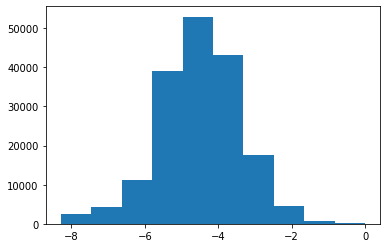

In [ ]:
plt.hist(np.log(Y.data.numpy()).reshape(-1, 1))

In [ ]:
del interaction_matrix
interaction_matrix = np.zeros((n_user, n_item))+np.log(1e-18)
interaction_matrix[np.array(freq.Customer_idx).astype(int), np.array(freq.Stock_idx).astype(int)] = np.log(np.array(freq.frequency)).astype(float)

In [ ]:
import torch

vmin, vmax = np.min(interaction_matrix), np.max(interaction_matrix)
vmin = np.min(np.log(freq.frequency))
scale_rating = (interaction_matrix-vmin)/(vmax-vmin)
ratings = torch.from_numpy(scale_rating).float()
''' normalize values by items - experiences show that it leads to increase MAE '''
for j in range(scale_rating.shape[1]):
    scale_rating[:, j] = scale_rating[:, j]/np.sum(scale_rating[:, j])
Identity = torch.from_numpy(scale_rating).float()
del scale_rating
print (ratings.shape, Identity.shape)

torch.Size([3655, 3696]) torch.Size([3655, 3696])


(array([13332557.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,   110038.,    66285.]),
 array([-4.0009208e+00, -3.5008287e+00, -3.0007367e+00, -2.5006444e+00,
        -2.0005524e+00, -1.5004604e+00, -1.0003684e+00, -5.0027621e-01,
        -1.8415452e-04,  4.9990791e-01,  1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

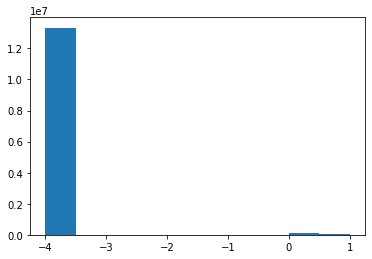

In [ ]:
plt.hist(ratings.data.numpy().reshape(-1, 1))

# Visualize functions

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def cal_silhoutte(X, cluster_labels):
    silhouette_score = silhouette_samples(X, cluster_labels)
    return silhouette_score

def cal_KMEANS_labels(X, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    return cluster_labels

def visualize_clusters(X, n_clusters = 6, cluster_labels = None, \
                                                scoring_method='silhouette'):
    if cluster_labels is None:
        cluster_labels = cal_KMEANS_labels(X, n_clusters)

    score, score_avg = None, None
    if scoring_method =='silhouette':
        score = cal_silhoutte(X, cluster_labels)
        score_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "the average %s score is : %.2f" \
                                            % (scoring_method, score_avg))

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 3)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = score[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Plot for the various clusters.")
    ax1.set_xlabel("The % score" % scoring_method)
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=score_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sbn

def visualize_learning(param_track, approx):
    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [np.exp(param[param_name]) for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
        print (param_name, param_value)
        break
    plt.hist(approx)
    plt.show()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def visualize(loss_track, param_track, approx):
    plt.plot(range(len(loss_track)), loss_track)
    plt.title('Loss')
    plt.show()

    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [param[param_name] for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
    plt.hist(approx)
    plt.show()

# Main

In [ ]:
import matplotlib.pyplot as plt
import seaborn as snb

In [ ]:
!pip install pyro-ppl

## utils

In [ ]:
def scale_minmax(x):
    vmin, vmax = torch.min(x), torch.max(x)
    return (x - vmin)/(vmax-vmin)

def invscale_minmax(x, vmin, vmax):
    return x * (vmax - vmin) + vmin

def get_mulogvar(x):
    mu, log_var = torch.mean(x), torch.log(torch.var(x))
    return mu, log_var

def log_norm2(x, mu, log_var):
    #similar log_norm2, but generate log_var instead var
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    # return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)
    return -0.5 * (log_var + np.log(2*np.pi)) -(0.5 * (1/torch.exp(log_var))* (x-mu)**2)

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target
        # self.KL_Div = KLDiv_Loss(size_average, reduce, reductio, log_target = True)

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm2(target, mu_q, logvar_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average = size_average, reduce = reduce, reduction = reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

In [ ]:
def sgd_training(model, loss_fn, obs, epochs=500):
    pyro.clear_param_store()
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)

    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        y = model().squeeze(-1) #model.forward(), squeeze ~ reshape(,-1)
        loss = loss_fn(y, obs)
        loss_track.append(loss.item())
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Epoch %d: " % step)
            r = model.get_approx()
            rmse = np.sqrt(np.mean((r.data.numpy() - obs.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

In [ ]:
def get_values_from_param(param, size, mean_value=0.0):
    # latent = np.random.normal(loc=param, scale = scale_latent, size = size)
    value = np.random.normal(loc = mean_value, scale = param, size = size)
    return value

In [ ]:
def get_values_from_tracker(Identity, K, param_dict):
    N, M = Identity.shape
    V = get_values_from_param(np.exp(0.5*param_dict['logvar_V_param']), (M, K))
    W = get_values_from_param(np.exp(0.5*param_dict['logvar_W_param']), (M, K))
    Y = get_values_from_param(np.exp(0.5*param_dict['logvar_Y_param']), (N, K))
    avg_similarity_weight = np.matmul(np.array(Identity.data.numpy()).astype(float), W)
    U = Y + avg_similarity_weight
    R = get_values_from_param(np.exp(0.5*param_dict['logvar_R_param']), (N, M), mean_value = sigmoid(np.matmul(U, V.T)))
    # print (R.shape, V.shape, U.shape, W.shape, Y.shape)
    return R, V, U, W, Y

## models

In [ ]:
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.distributions as dist

In [ ]:
class Neural_PMF_2(PyroModule):
    def __init__(self, Identity, latent=16):
        super().__init__()
        user_dim, item_dim = Identity.shape
        self.user_dim, self.item_dim, self.latent_dim = user_dim, item_dim, latent
        self.Identity = Identity

        self.logvar_V_param  = torch.nn.Parameter(torch.ones(self.latent_dim), requires_grad=True)
        self.logvar_W_param  = torch.nn.Parameter(torch.ones(self.latent_dim), requires_grad=True)
        self.logvar_U_param  = torch.nn.Parameter(torch.ones(self.latent_dim),requires_grad=True)
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)

        self.U, self.W, self.Y, self.R = None, None, None, None

    def generate(self):
        self.V = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_V_param)).expand([self.item_dim, self.latent_dim]).to_event(1))
        self.W = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_W_param)).expand([self.item_dim, self.latent_dim]).to_event(1))
        self.Y = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_U_param)).expand([self.user_dim, self.latent_dim]).to_event(1))
        avg_similarity_weight = torch.mm(self.Identity, self.W)
        self.U = self.Y + avg_similarity_weight
        self.mean_R = torch.sigmoid(torch.mm(self.U, self.V.T))
        self.R = PyroSample(dist.Normal(loc=self.mean_R, scale=torch.exp(0.5*self.logvar_R_param)))
        return self.R

    def get_param(self):
        return {'logvar_V_param':0.0+self.logvar_V_param.data.numpy(), 'logvar_W_param':0.0+self.logvar_W_param.data.numpy(),\
                'logvar_Y_param':0.0+self.logvar_U_param.data.numpy(), 'logvar_R_param':0.0+self.logvar_R_param.item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

In [ ]:
class NeuralCF(torch.nn.Module):
    def __init__(self, n_user, n_item, n_latent=16):
        super(NeuralCF, self).__init__()
        self.n_user, self.n_item, self.n_latent = n_user, n_item, n_latent
        self.user_emb = torch.nn.Embedding(n_user, n_latent, sparse=True)
        self.item_emb = torch.nn.Embedding(n_item, n_latent, sparse=True)
        self.FC = torch.nn.Linear(n_latent, 1)

    def forward(self, X_user, X_item, Y):
        user_latent = self.user_emb(X_user)
        item_latent = self.item_emb(X_item)
        r = torch.sigmoid(self.FC(user_latent + item_latent))
        return torch.nn.functional.mse_loss(r, Y, reduction="sum")

# ProbMF

In [ ]:
model = Neural_PMF_2(Identity)
loss_track, param_track = sgd_training(model, ELBO_Loss(), ratings, epochs=50)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 0.737815, RMSE = 4.786328 
+ Param:  {'logvar_V_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_W_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_Y_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_R_param': 1.0}
Epoch 4: 
+ Loss = 0.737815, RMSE = 4.787800 
+ Param:  {'logvar_V_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_W_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_Y_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_R_param': 1.0}
Epoch 9: 
+ Loss = 0.737815, RMSE = 4.788246 
+ Param:  {'logvar_V_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32),

## Applying

In [ ]:
y_scaled = scale_minmax(torch.log(Y)).float()

(array([ 2596.,  4174., 11242., 39117., 52909., 43081., 17607.,  4440.,
          830.,   327.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

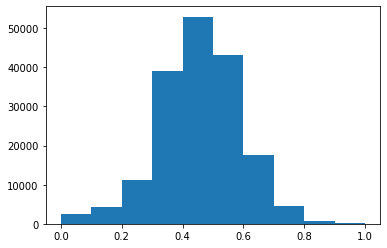

In [ ]:
plt.hist(y_scaled.data.numpy())

In [ ]:
def training(X_user, X_item, y, batch_size=2500):
    loss_fn = torch.nn.MSELoss()
    model = NeuralCF(n_user, n_item, 16)
    optim = torch.optim.SGD (model.parameters(), lr = 0.1)

    epochs = 20
    n_samples = len(X_user)
    idx = np.array(range(n_samples))
    n_batch = int((n_samples-1)/batch_size )+1

    for epoch in range(epochs):
        np.random.shuffle(idx)
        batch_loss = 0.0
        for batch in range(n_batch):
            batch_idx = idx[batch*batch_size:(batch+1)*batch_size]
            loss = model(X_user, X_item, y)
            model.zero_grad()
            loss.backward()
            batch_loss += loss/n_batch
        if (epoch == 0) or (epoch % (epochs/5)==(epochs/5)-1):
            print ("Epoch %3d: %.4f " % (epoch, batch_loss.item()))
        optim.step()

In [ ]:
training(X_user, X_item, y_scaled, batch_size=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([176323])) that is different to the input size (torch.Size([176323, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]


In [ ]:
y_scaled

tensor([1.0000, 0.6149, 0.5659,  ..., 0.5519, 0.5519, 0.5519])